In [91]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from datetime import datetime
from scipy.optimize import curve_fit, fsolve
# directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'
directory_path = 'Z:\Lab Data\Qudit_Ramsey_raw_data\Line_signal_compensation_data'

# Fixed frequency: 2π
def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t + phi) + offset

def combined_decay(t, A, T2_G, T2_L):
    gaussian_decay = np.exp(-(t / T2_G)**2)
    lorentzian_decay = np.exp(-t / T2_L)
    return A * gaussian_decay * lorentzian_decay

def parse_filename(filename):
    pattern = (
        r"Ramsey_qubit_\[(-?\d+),(-?\d+),(-?\d+)\]_LTWaitTime(\d+)us_comp_False_(\d{8})_(\d{4}).txt"
    )
    match = re.search(pattern, filename)
    # print(match)
    if match:
        m = int(match.group(1))
        F = int(match.group(2))
        mF = int(match.group(3))
        wait_time = int(match.group(4))
        date_str = match.group(5) + match.group(6)  # "YYYYMMDDHHMM"
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')
        return (m, F, mF, wait_time, date_time)
    else:
        return (None, None, None, None, None)

def search_files_by_transitions(directory, target_transition, target_date_times=None):
    wait_time_list = []
    raw_file_paths_list = []
    final_params = (None, None, None)
    for filename in os.listdir(directory):
        if filename.startswith('Ramsey_qubit'):
            (m, F, mF, wait_time, date_time) = parse_filename(filename)
            if None in (m, F, mF, wait_time, date_time):
                continue
            if (m, F, mF) == target_transition:
                if target_date_times and date_time not in target_date_times:
                    continue  # Skip if date_time is not in the target list
                final_params = (m, F, mF)
                file_path = os.path.join(directory, filename)
                raw_data_filenames = extract_raw_data_filenames(file_path)
                Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data\\'
                raw_data_filepaths = [os.path.join(Z_drive_raw_data, raw_filename) for raw_filename in raw_data_filenames]
                wait_time_list.append(wait_time)
                raw_file_paths_list.append(raw_data_filepaths)
    return wait_time_list, raw_file_paths_list, final_params

def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [
        name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')
    ]
    return raw_data_filenames

if __name__ == "__main__":
    target_transition = (-1, 4, -3)  # Replace with desired values
    # target_date_times = {datetime(2025, 3, 13, 18, 4),datetime(2025, 3, 13, 20, 49),datetime(2025, 3, 13, 21, 32)} 
    # target_date_times = {datetime(2025, 3, 12, 21, 43),datetime(2025, 3, 12, 23, 46),datetime(2025, 3, 13, 6, 49)} 
    # target_date_times = {datetime(2025, 9, 25, 18, 2)} # new data without FNCS
    # target_date_times = {datetime(2025, 9, 25, 18, 57)} # new data with FNCS
    # target_date_times = {datetime(2025, 9, 25, 20, 3), datetime(2025, 9, 26, 7, 36)} # new data with FNCS - fine scan
    # target_date_times = {datetime(2025, 10, 3, 15, 18)} # RFSoC data 50us steps
    # target_date_times = {datetime(2025, 10, 8, 17, 59),datetime(2025, 10, 8, 17, 44)}
    target_date_times = {datetime(2025, 11, 26, 16, 48), datetime(2025, 11, 26, 20, 41),datetime(2025, 11, 26, 23, 35)} # RFSoC phase coherent scans
    wait_time_list, raw_file_paths_list, final_params = search_files_by_transitions(directory_path, target_transition, target_date_times)
    m, F, mF = final_params
    print(f"Parameters: m={m}, F={F}, mF={mF}")
    print("\nWait times and corresponding raw data file paths:")
    for wt, fp_list in zip(wait_time_list, raw_file_paths_list):
        print(f"\nWait time: {wt} us")
        
        for fp in fp_list:
            print(f"  {fp}")


Parameters: m=-1, F=4, mF=-3

Wait times and corresponding raw data file paths:

Wait time: 0 us
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_121
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_122
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_123
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_124
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_125
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_126
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_127
  Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_11\\2025_11_26\\qudit_ramsey_scan_bused_128
  Z:\\Lab Data\

In [92]:
import numpy as np
import json

# --------------------------------
# Existing Functions (Unchanged)
# --------------------------------

def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)
    # Truncate outliers at the start and end
    data_sorted = data_sorted[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    return threshold, data_sorted

def process_raw_data_files(raw_data_filepaths):
    arrays = []
    # Read and process the data from all raw data files
    for file_path in raw_data_filepaths:
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"])
    # Convert to numpy array
    hist_data = np.array(arrays)
    
    # Flatten the hist_data and compute shelving threshold
    flat_hist_data = hist_data.flatten()
    threshold, _ = get_shelving_threshold(flat_hist_data)

    # Prepare for further processing (3D array)
    arrays_3d = []
    for file_path in raw_data_filepaths[:]:
        arrays = []
        with open(file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                arrays.append(data[0]["0"][:])
        if len(arrays) == 0:
            arrays = list(np.full((100, 4), 40))  # fallback if no data
        arrays_3d.append(arrays)

    bool_array = np.array(arrays_3d) > threshold
    print(bool_array.shape)
    result_matrix = np.full((10,250,3), False, dtype=bool)
    # Identify the first occurrence of shelving (True value)
    for matrix_index in range(bool_array.shape[0]):
        for row_index in range(bool_array.shape[1]):
            true_indices = np.where(bool_array[matrix_index, row_index, :])
            # print(bool_array[matrix_index, row_index, :])
            # if true_indices[0].size > 0:
            #     first_true_index = true_indices[0]
            #     # We exclude cases where the first-true index is 0 or 1
            #     if first_true_index[0] != 0:
            #         # print(first_true_index)
            #         result_matrix[matrix_index, row_index, first_true_index[0]] = True
            data_bool = bool_array[matrix_index, row_index, :]
            if data_bool[0] == False:
                if data_bool[1] == True:
                    result_matrix[matrix_index, row_index, 1] = True
                if data_bool[1] == False:
                    result_matrix[matrix_index, row_index, 2] = True

    # Filter data and compute percentages used
    filtered_data_array = []
    percentage_data_used = []
    num_points = bool_array.shape[0]  # Determine the number of data points
    # print(result_matrix)
    for i in range(num_points):
        data = result_matrix[i]
        rows_with_any_true = data.any(axis=1)
        filtered_data = data[rows_with_any_true]
        filtered_data_array.append(filtered_data)
        percentage_data_used.append(filtered_data.shape[0] / data.shape[0])

    # Compute ket data by averaging the filtered data
    def find_errors(num_SD, full_data_array, exp_num):
        upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) + np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        lower_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                       (1 + (num_SD**2 / exp_num))) - np.sqrt(
                           ((full_data_array *
                             (1 - full_data_array) * num_SD**2) / exp_num) +
                           (num_SD**4 / (4 * exp_num**2))
                       ) / (1 + (num_SD**2 / exp_num))

        return lower_error, upper_error

    ket_data = []
    exp_num_list = []
    for filtered_data in filtered_data_array:
        # Average across the 3rd dimension's index=2
        # print(filtered_data)
        ket_data.append(np.mean(filtered_data, axis=0)[1])
        exp_num_list.append(len(filtered_data))
    print(exp_num_list)
    lower_error, upper_error = find_errors(1, np.array(ket_data), np.array(exp_num_list))
    
    return ket_data, lower_error, upper_error


# ------------------------------------------------
# New Function Using Parallel Lists (NOT a dict)
# ------------------------------------------------
def process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list):
    """
    Instead of passing a dictionary {wait_time: [file1, file2, ...]},
    we pass in two parallel lists:
      1) wait_time_list[i] 
      2) raw_file_paths_list[i]

    We will return four separate lists:
      - processed_wait_times[i]
      - ket_data_list[i]
      - lower_error_list[i]
      - upper_error_list[i]

    Each index i in these return lists corresponds to the same data set.
    """
    processed_wait_times = []
    ket_data_list = []
    lower_error_list = []
    upper_error_list = []
    
    # Iterate over each index in the parallel lists
    for i, wait_time in enumerate(wait_time_list):
        # Fetch corresponding raw data file paths
        raw_data_filepaths = raw_file_paths_list[i]

        # Process the raw data
        ket_data, lower_error, upper_error = process_raw_data_files(raw_data_filepaths)

        # Store results in the four lists
        processed_wait_times.append(wait_time)

        # ket_data is already a list of floats
        # lower_error and upper_error are arrays (same shape as ket_data)
        # The original code does:
        #   final_lower = ket_data - lower_error
        #   final_upper = upper_error - ket_data
        # so we replicate that logic
        ket_data_arr = np.array(ket_data)
        final_lower_error = np.abs(ket_data_arr - np.array(lower_error))
        final_upper_error = np.abs(np.array(upper_error) - ket_data_arr)

        ket_data_list.append(ket_data)
        lower_error_list.append(final_lower_error)
        upper_error_list.append(final_upper_error)

    return processed_wait_times, ket_data_list, lower_error_list, upper_error_list

wait_time_list, raw_file_paths_list = zip(
    *sorted(zip(wait_time_list, raw_file_paths_list), key=lambda x: x[0])
)

# Convert back to lists if needed
wait_time_list = list(wait_time_list)
raw_file_paths_list = list(raw_file_paths_list)

(
    processed_wait_times, 
    ket_data_list, 
    lower_error_list, 
    upper_error_list
) = process_all_wait_times_in_lists(wait_time_list, raw_file_paths_list)

# Printing example output
print("\nProcessed Data in Parallel Lists:")
for wt, ket_vals, le_vals, ue_vals in zip(processed_wait_times, ket_data_list, lower_error_list, upper_error_list):
    print(f"\nWait Time: {wt} us")
    print(f"Ket Data (list): {ket_vals}")
    print(f"Lower Error (array): {le_vals}")
    print(f"Upper Error (array): {ue_vals}")


(10, 250, 2)
[232, 230, 234, 238, 235, 228, 239, 235, 235, 226]
(10, 250, 2)
[226, 232, 236, 230, 235, 234, 231, 236, 241, 230]
(10, 250, 2)
[234, 236, 241, 239, 238, 231, 237, 239, 237, 230]
(10, 250, 2)
[232, 233, 236, 233, 228, 238, 231, 241, 227, 239]
(10, 250, 2)
[230, 235, 236, 229, 238, 236, 233, 238, 229, 228]
(10, 250, 2)
[232, 230, 238, 237, 245, 236, 226, 238, 236, 235]
(10, 250, 2)
[234, 240, 241, 235, 230, 234, 238, 234, 231, 242]
(10, 250, 2)
[236, 234, 234, 233, 231, 233, 224, 236, 237, 231]
(10, 250, 2)
[228, 238, 237, 234, 235, 235, 233, 234, 233, 236]
(10, 250, 2)
[232, 231, 239, 227, 231, 237, 236, 228, 232, 230]
(10, 250, 2)
[234, 234, 237, 230, 234, 234, 242, 238, 232, 233]
(10, 250, 2)
[235, 230, 234, 233, 236, 239, 234, 238, 230, 238]
(10, 250, 2)
[233, 231, 232, 233, 234, 232, 236, 231, 232, 236]
(10, 250, 2)
[235, 234, 227, 239, 232, 232, 229, 239, 233, 234]
(10, 250, 2)
[231, 239, 233, 230, 237, 223, 230, 233, 237, 237]
(10, 250, 2)
[234, 227, 241, 238, 236, 2

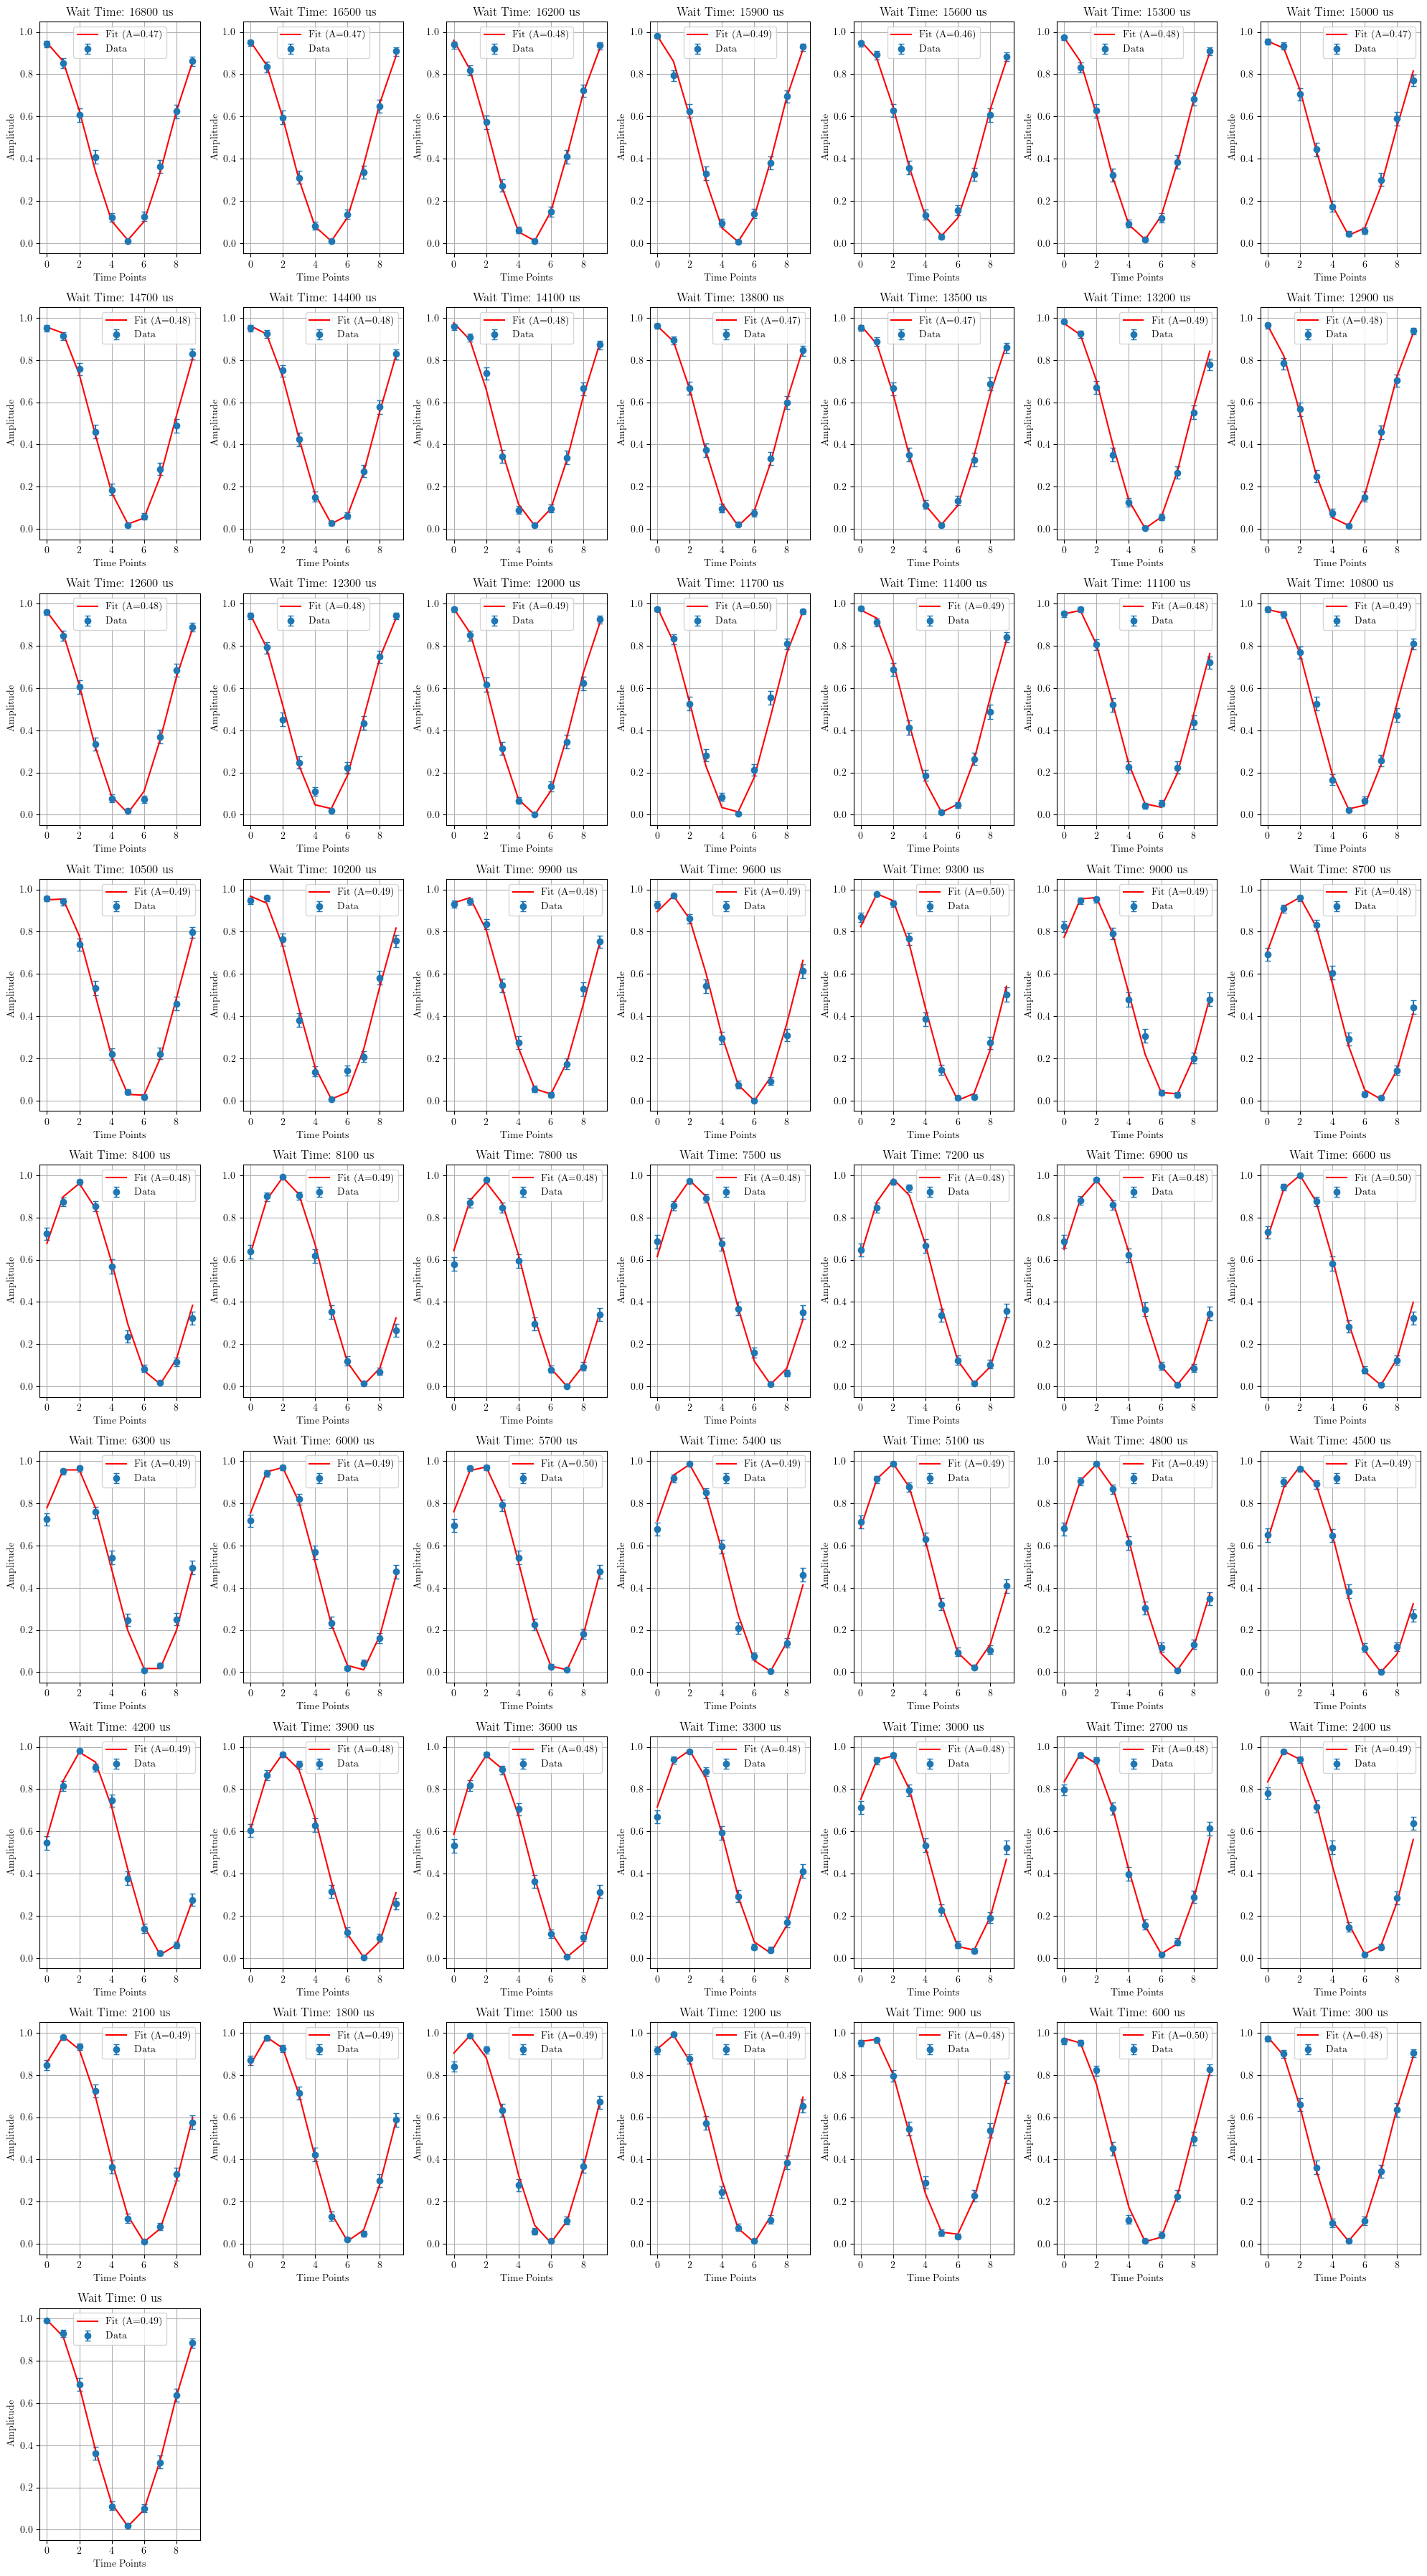


Fitted Results (Lists):
Wait Time: 0 us
  Params (A, phi, offset) = 0.489, 0.052, 0.505
  Amplitude (2*|A|) = 0.979 ± 0.010
  Phase = 0.052 ± 0.024
Wait Time: 300 us
  Params (A, phi, offset) = 0.484, 0.006, 0.497
  Amplitude (2*|A|) = 0.969 ± 0.011
  Phase = 0.006 ± 0.024
Wait Time: 600 us
  Params (A, phi, offset) = 0.496, 0.245, 0.492
  Amplitude (2*|A|) = 0.993 ± 0.011
  Phase = 0.245 ± 0.021
Wait Time: 900 us
  Params (A, phi, offset) = 0.481, 0.348, 0.507
  Amplitude (2*|A|) = 0.961 ± 0.013
  Phase = 0.348 ± 0.024
Wait Time: 1200 us
  Params (A, phi, offset) = 0.493, 0.531, 0.498
  Amplitude (2*|A|) = 0.986 ± 0.009
  Phase = 0.531 ± 0.023
Wait Time: 1500 us
  Params (A, phi, offset) = 0.491, 0.590, 0.496
  Amplitude (2*|A|) = 0.982 ± 0.010
  Phase = 0.590 ± 0.023
Wait Time: 1800 us
  Params (A, phi, offset) = 0.488, 0.766, 0.496
  Amplitude (2*|A|) = 0.976 ± 0.012
  Phase = 0.766 ± 0.023
Wait Time: 2100 us
  Params (A, phi, offset) = 0.490, 0.736, 0.496
  Amplitude (2*|A|) = 0.9

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# # Fixed frequency: 2π
# def sine_function(t, A, phi, offset):
#     return A * np.cos(2 * np.pi/10 * t + phi) + offset

# def fit_sine_curve(ket_data, lower_error, upper_error):
#     if len(ket_data) == 5:
#         t = 2*np.arange(len(ket_data))
#     else:
#         t = np.arange(len(ket_data))
#     valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
#     t_valid = t[valid_indices]
#     ket_data_valid = np.array(ket_data)[valid_indices]
#     lower_error_valid = np.array(lower_error)[valid_indices]
#     upper_error_valid = np.array(upper_error)[valid_indices]

#     sigma = (upper_error_valid + lower_error_valid) / 2.0
#     if np.any(sigma <= 0):
#         nonzero = sigma[sigma > 0]
#         replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
#         sigma[sigma <= 0] = replacement

#     initial_guess = [
#         (np.max(ket_data_valid) - np.min(ket_data_valid))/2,
#         0,
#         np.mean(ket_data_valid)
#     ]
#     try:
#         params, covariance = curve_fit(
#             sine_function,
#             t_valid,
#             ket_data_valid,
#             p0=initial_guess,
#             sigma=sigma,
#             absolute_sigma=True, maxfev=10000
#         )
#         if covariance is not None:
#             errors = np.sqrt(np.diag(covariance))
#             errors = [err if np.isfinite(err) else None for err in errors]
#         else:
#             errors = [None] * len(params)

#         return params, errors
#     except RuntimeError:
#         return None, None

def sine_function(t, A, phi, offset):
    return A * np.cos(2 * np.pi/10 * t - phi) + offset

def fit_sine_curve(ket_data, lower_error, upper_error):
    if len(ket_data) == 5:
        t = 2*np.arange(len(ket_data))
    else:
        t = np.arange(len(ket_data))
    valid_indices = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    t_valid = t[valid_indices]
    ket_data_valid = np.array(ket_data)[valid_indices]
    lower_error_valid = np.array(lower_error)[valid_indices]
    upper_error_valid = np.array(upper_error)[valid_indices]

    sigma = (upper_error_valid + lower_error_valid) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    A0 = (np.max(ket_data_valid) - np.min(ket_data_valid))/2
    A0 = np.clip(A0, 0.0, 0.5)
    initial_guess = [0.44, 0.004, 0.46]

    try:
        params, covariance = curve_fit(
            sine_function,
            t_valid,
            ket_data_valid,
            p0=initial_guess,
            sigma=sigma,
            absolute_sigma=True,
            maxfev=10000,
            bounds=([0.0, -np.pi, 0], [0.5, np.pi, 1])
        )
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            errors = [err if np.isfinite(err) else None for err in errors]
        else:
            errors = [None] * len(params)
        return params, errors
    except RuntimeError:
        return None, None


def fit_all_wait_times_to_sine_in_lists(wait_time_list,
                                        ket_data_list,
                                        lower_error_list,
                                        upper_error_list):
    fit_wait_times_list = []
    fit_params_list = []
    fit_amplitudes_list = []
    fit_amplitude_errors_list = []
    fit_phases_list = []
    fit_phase_errors_list = []
    
    for i in range(len(wait_time_list)):
        wt = wait_time_list[i]
        kd = ket_data_list[i]
        le = lower_error_list[i]
        ue = upper_error_list[i]
        
        if len(kd) > 4:
            params, errors = fit_sine_curve(kd, le, ue)
            if params is not None and errors is not None and errors[0] is not None:
                A, phi, offset = params
                amplitude = 2.0 * abs(A)
                amplitude_error = 2.0 * errors[0] if errors[0] is not None else None
                phase_error = errors[1]

                fit_wait_times_list.append(wt)
                fit_params_list.append(params)
                fit_amplitudes_list.append(amplitude)
                fit_amplitude_errors_list.append(amplitude_error)
                fit_phases_list.append(phi)
                fit_phase_errors_list.append(phase_error)
        else:
            fit_wait_times_list.append(wt)
            fit_params_list.append([None, None, None])
            fit_amplitudes_list.append(None)
            fit_amplitude_errors_list.append(None)
            fit_phases_list.append(None)
            fit_phase_errors_list.append(None)
    return (
        fit_wait_times_list,
        fit_params_list,
        fit_amplitudes_list,
        fit_amplitude_errors_list,
        fit_phases_list,
        fit_phase_errors_list
    )

def plot_sine_fits_in_lists(wait_time_list,
                            ket_data_list,
                            lower_error_list,
                            upper_error_list,
                            fit_wait_times_list,
                            fit_params_list):
    num_plots = len(wait_time_list)
    num_columns = 7
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i in range(num_plots):
        wt = wait_time_list[::-1][i]
        kd = ket_data_list[::-1][i]
        le = lower_error_list[::-1][i]
        ue = upper_error_list[::-1][i]
        
        t = np.arange(len(kd))
        ax = axes[i]
        ax.errorbar(
            t,
            kd,
            yerr=[abs(le), abs(ue)],
            fmt='o',
            label='Data',
            capsize=3
        )
        
        if wt in fit_wait_times_list:
            j = fit_wait_times_list[::-1].index(wt)
            A, phi, offset = fit_params_list[::-1][i]
            if A is not None:
                fit_curve = sine_function(t, A, phi, offset)
                ax.plot(t, fit_curve, color='red', label=f'Fit (A={A:.2f})')

        ax.set_title(f'Wait Time: {wt} us')
        ax.set_xlabel('Time Points')
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel('Amplitude')
        ax.grid()
        ax.legend()
    
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.savefig('laser_noise_phase_scans.png', dpi=300)
    plt.show()

(
    fit_wait_times_list,
    fit_params_list,
    fit_amplitudes_list,
    fit_amplitude_errors_list,
    fit_phases_list,
    fit_phase_errors_list
) = fit_all_wait_times_to_sine_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list
)

plot_sine_fits_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list,
    fit_wait_times_list,
    fit_params_list
)

print("\nFitted Results (Lists):")
for i, wt in enumerate(fit_wait_times_list):
    A, phi, offset = fit_params_list[i]
    amp = fit_amplitudes_list[i]
    amp_err = fit_amplitude_errors_list[i]
    phase = fit_phases_list[i]
    phase_err = fit_phase_errors_list[i]
    print(f"Wait Time: {wt} us")
    print(f"  Params (A, phi, offset) = {A:.3f}, {phi:.3f}, {offset:.3f}")
    print(f"  Amplitude (2*|A|) = {amp:.3f} ± {amp_err:.3f}")
    print(f"  Phase = {phase:.3f} ± {phase_err:.3f}")


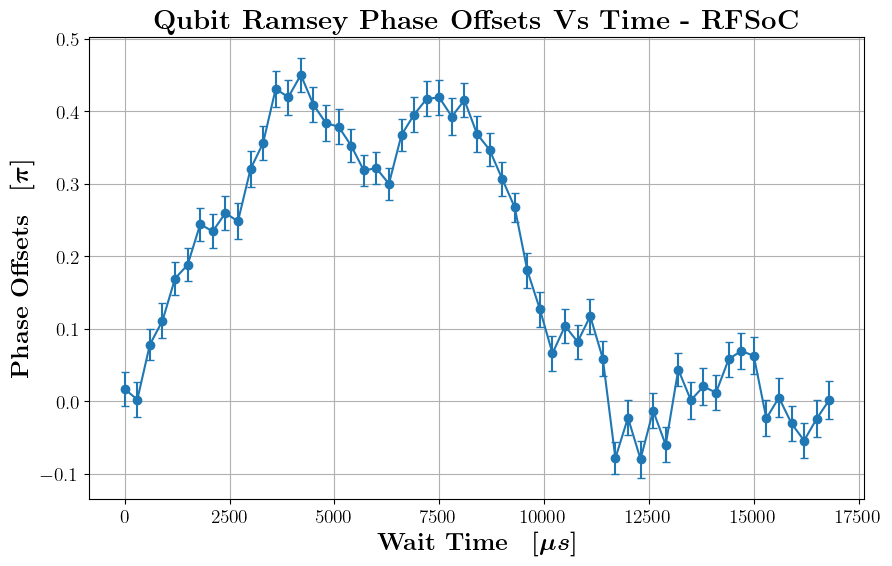

In [94]:
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

plt.figure(figsize=(10, 6))
# plt.plot(
#     fit_wait_times_list,
#     fit_phases_list)
plt.errorbar(
    fit_wait_times_list,
    np.array(fit_phases_list)/np.pi,
    yerr=fit_phase_errors_list,
    fmt='-o',
    capsize=3
)

plt.xlabel(r'\boldmath$\textbf{Wait Time}\quad [\mu s]$', fontsize=18)
plt.ylabel(r'\boldmath$\textbf{Phase Offsets}\quad [\pi]$', fontsize=18)
plt.title(r'\textbf{Qubit Ramsey Phase Offsets Vs Time - RFSoC}', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.savefig('0_2_0_phase_offsets_for_laser_noise_with_RFSoC.png', dpi=300, bbox_inches="tight")
plt.show()

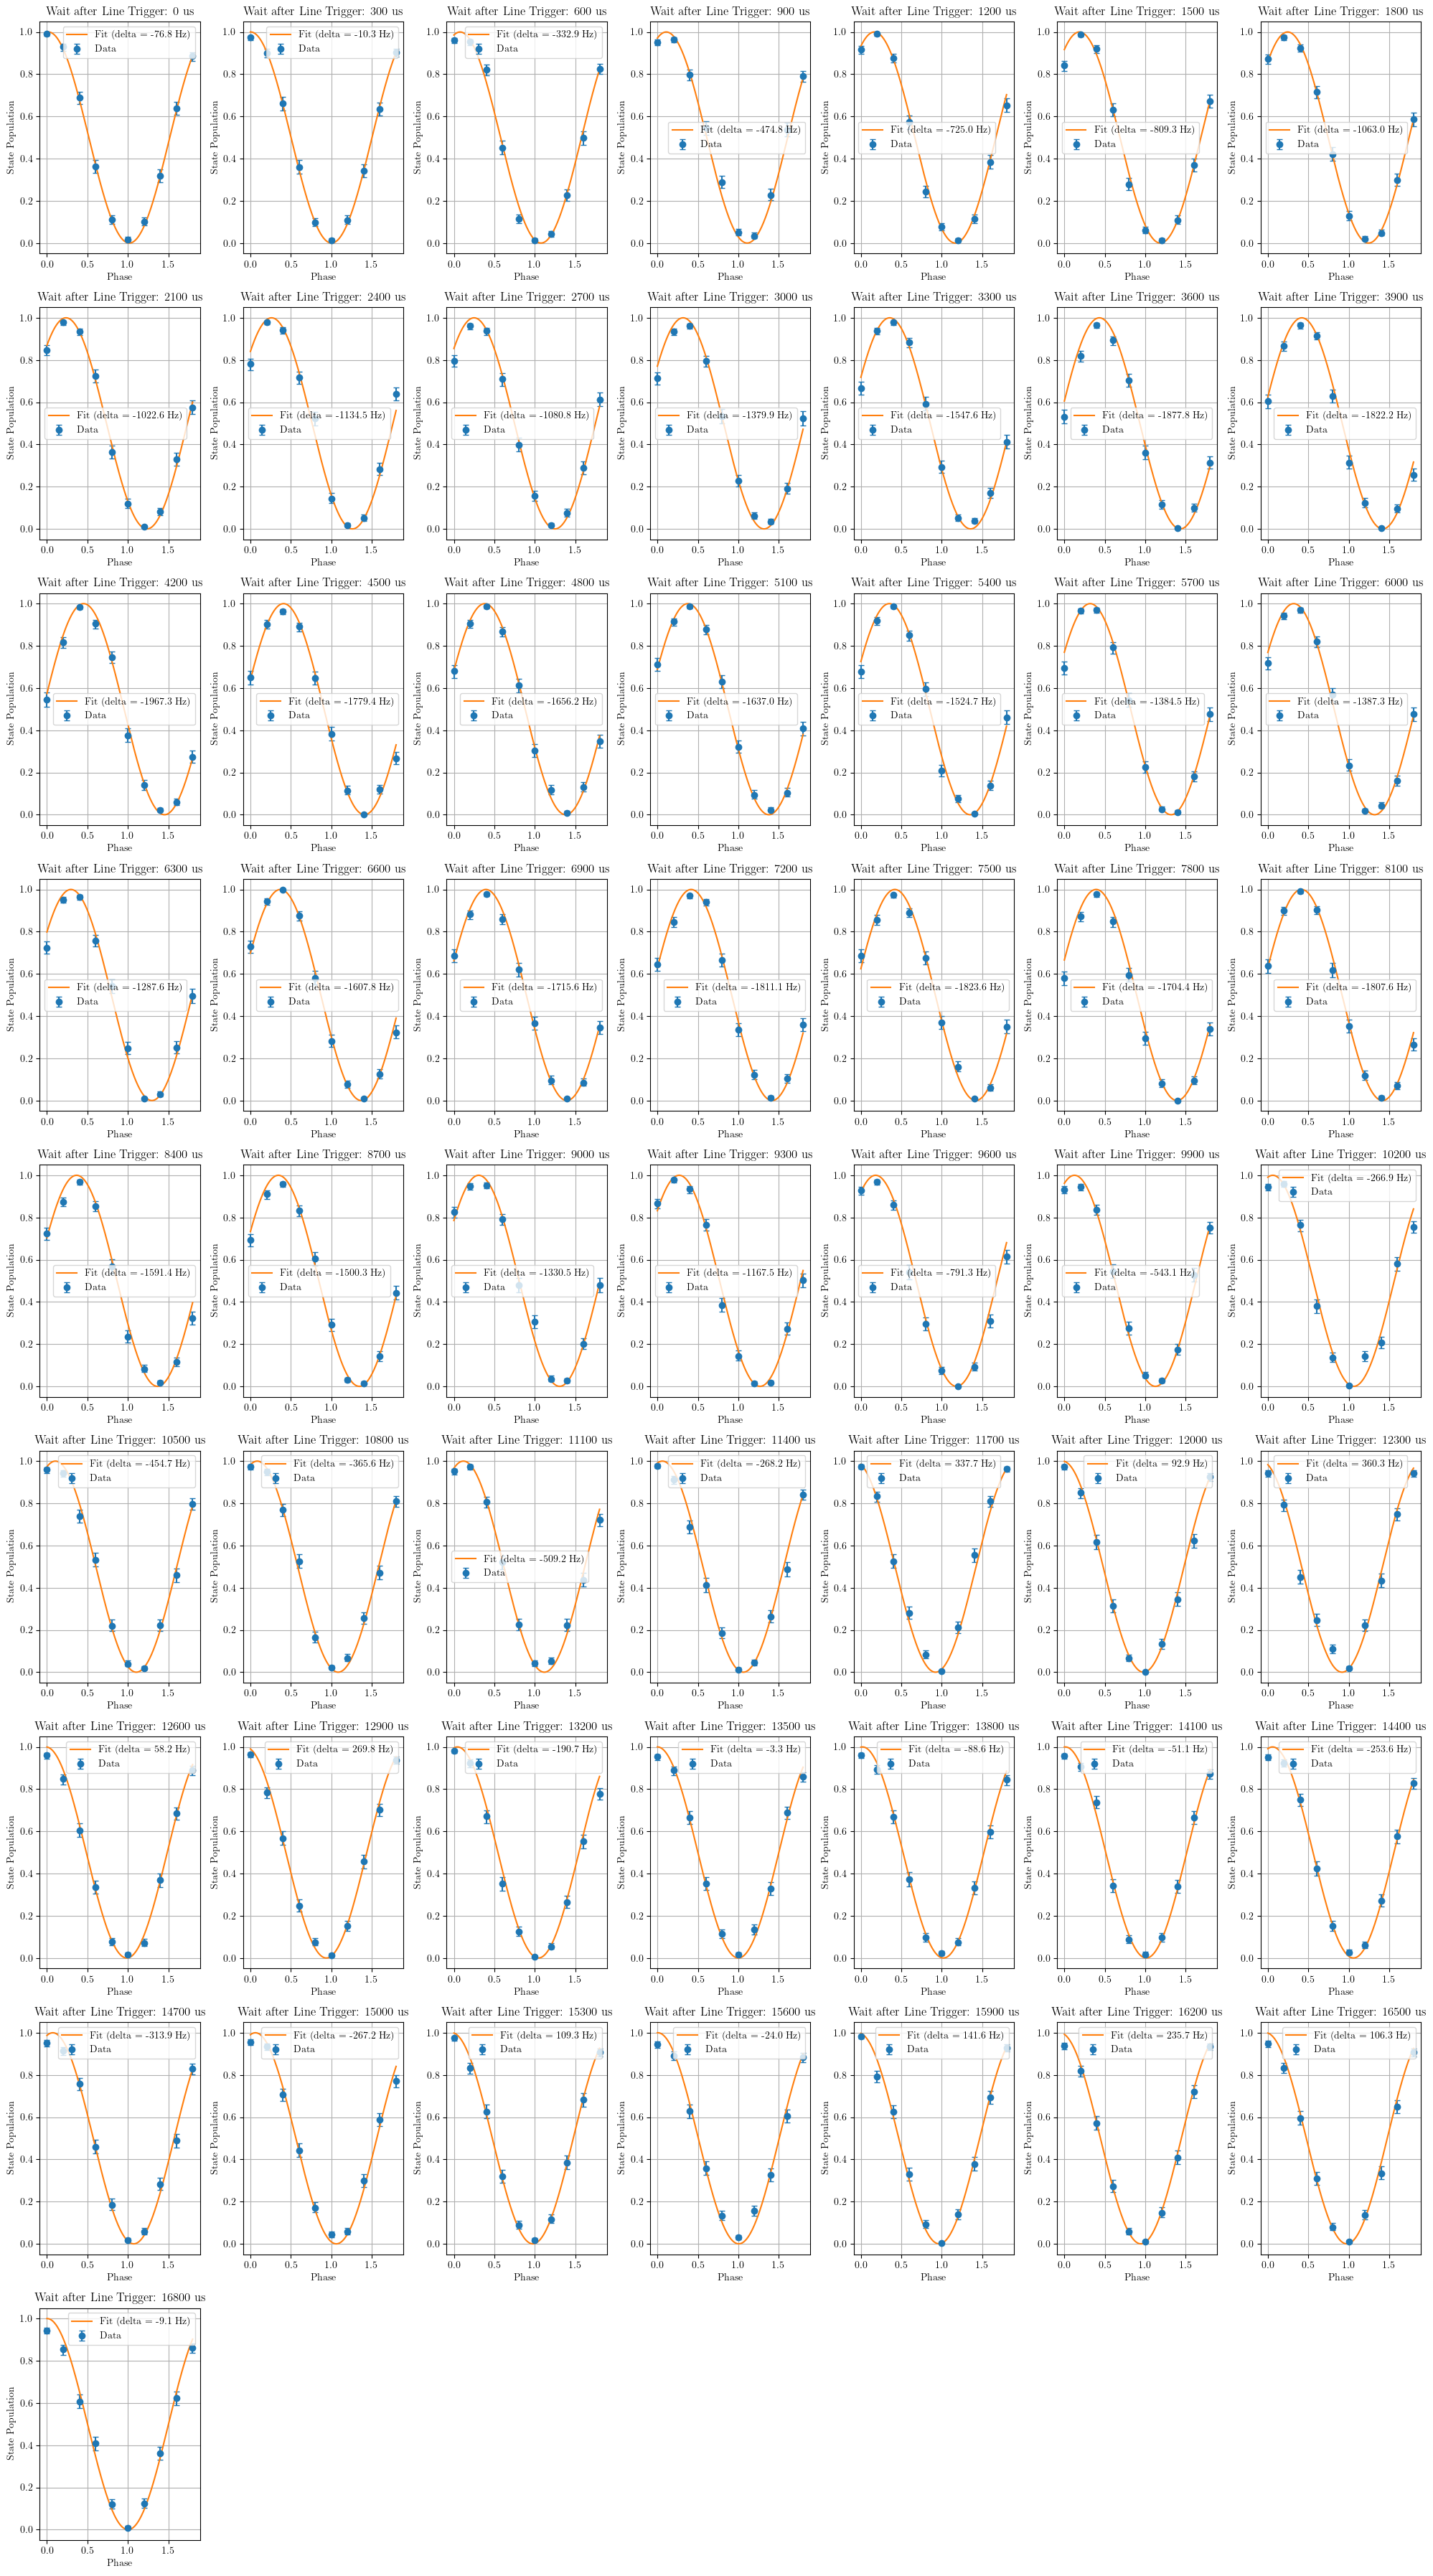


Fitted Detunings:
0: δ = -76.754 Hz ± 31.764 Hz
300: δ = -10.271 Hz ± 32.337 Hz
600: δ = -332.893 Hz ± 28.705 Hz
900: δ = -474.817 Hz ± 31.749 Hz
1200: δ = -725.009 Hz ± 31.249 Hz
1500: δ = -809.324 Hz ± 30.976 Hz
1800: δ = -1063.048 Hz ± 30.844 Hz
2100: δ = -1022.599 Hz ± 31.509 Hz
2400: δ = -1134.545 Hz ± 31.058 Hz
2700: δ = -1080.824 Hz ± 32.440 Hz
3000: δ = -1379.858 Hz ± 32.317 Hz
3300: δ = -1547.580 Hz ± 31.222 Hz
3600: δ = -1877.789 Hz ± 32.512 Hz
3900: δ = -1822.232 Hz ± 32.083 Hz
4200: δ = -1967.272 Hz ± 31.761 Hz
4500: δ = -1779.427 Hz ± 32.206 Hz
4800: δ = -1656.169 Hz ± 33.016 Hz
5100: δ = -1636.996 Hz ± 32.091 Hz
5400: δ = -1524.688 Hz ± 29.918 Hz
5700: δ = -1384.468 Hz ± 28.989 Hz
6000: δ = -1387.291 Hz ± 29.616 Hz
6300: δ = -1287.614 Hz ± 28.799 Hz
6600: δ = -1607.819 Hz ± 27.805 Hz
6900: δ = -1715.630 Hz ± 32.889 Hz
7200: δ = -1811.115 Hz ± 32.373 Hz
7500: δ = -1823.565 Hz ± 32.675 Hz
7800: δ = -1704.393 Hz ± 33.142 Hz
8100: δ = -1807.634 Hz ± 31.918 Hz
8400: δ = -1591

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.optimize import curve_fit

def unitary_product_with_ket_zero(pi_time, T_between_pulses, delta, phase_pi):
    omega = np.pi / (pi_time * 1e-6)
    t_pi_over_2 = (pi_time * 1e-6) / 2

    def U1(omega, t):
        H = np.array([[0, omega / 2],
                      [omega / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U_wait(delta, t):
        H = np.array([[0, 0],
                      [0, delta]], dtype=complex)
        return expm(-1j * H * t)

    def U2(omega, delta, phase_pi, t):
        phase = np.pi * phase_pi
        H = np.array([[0, omega * np.exp(-1j * phase) / 2],
                      [omega * np.exp(1j * phase) / 2, delta]], dtype=complex)
        return expm(-1j * H * t)

    U1_mat = U1(omega, t_pi_over_2)
    U_wait_mat = U_wait(delta, T_between_pulses)
    U2_mat = U2(omega, delta, phase_pi, t_pi_over_2)

    product = U2_mat @ U_wait_mat @ U1_mat
    ket_zero = np.array([1, 0], dtype=complex)
    result = product @ ket_zero
    state_pop = np.abs(result) ** 2
    return state_pop[1]

def fit_detuning_for_one_dataset(ket_data,
                                 lower_error,
                                 upper_error,
                                 phase_list,
                                 pi_time,
                                 T_between_pulses,
                                 initial_delta_guess=2 * np.pi * 100):
    ket_data = np.array(ket_data, dtype=float)
    lower_error = np.array(lower_error, dtype=float)
    upper_error = np.array(upper_error, dtype=float)
    phase_array = np.array(phase_list, dtype=float)

    if ket_data.shape[0] != phase_array.shape[0]:
        raise ValueError("ket_data and phase_list must have the same length.")

    valid = ~np.isnan(ket_data) & ~np.isnan(lower_error) & ~np.isnan(upper_error)
    if not np.any(valid):
        return None, None

    phases_valid = phase_array[valid]
    ket_data_valid = ket_data[valid]
    lower_error_valid = lower_error[valid]
    upper_error_valid = upper_error[valid]

    sigma = (np.abs(upper_error_valid) + np.abs(lower_error_valid)) / 2.0
    if np.any(sigma <= 0):
        nonzero = sigma[sigma > 0]
        replacement = np.min(nonzero) if len(nonzero) > 0 else 1.0
        sigma[sigma <= 0] = replacement

    def ramsey_model(phase_pi, delta):
        return np.array([
            unitary_product_with_ket_zero(pi_time, T_between_pulses, delta, ph)
            for ph in phase_pi
        ])

    try:
        params, covariance = curve_fit(
            ramsey_model,
            phases_valid,
            ket_data_valid,
            p0=[initial_delta_guess],
            sigma=sigma,
            absolute_sigma=True,
            maxfev=20000
        )
        delta_opt = params[0]
        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))
            delta_err = errors[0] if np.isfinite(errors[0]) else None
        else:
            delta_err = None
        return delta_opt, delta_err
    except RuntimeError:
        return None, None

def fit_all_wait_times_to_detuning(wait_time_list,
                                   ket_data_list,
                                   lower_error_list,
                                   upper_error_list,
                                   phase_list,
                                   pi_time,
                                   T_between_pulses,
                                   initial_delta_guess=2 * np.pi * 100):
    fit_wait_times_list = []
    fit_detunings_list = []
    fit_detuning_errors_list = []

    for i in range(len(wait_time_list)):
        wt_label = wait_time_list[i]
        kd = ket_data_list[i]
        le = lower_error_list[i]
        ue = upper_error_list[i]

        if len(kd) >= 4:
            delta_opt, delta_err = fit_detuning_for_one_dataset(
                kd, le, ue, phase_list, pi_time, T_between_pulses, initial_delta_guess
            )
            fit_wait_times_list.append(wt_label)
            fit_detunings_list.append(delta_opt)
            fit_detuning_errors_list.append(delta_err)
        else:
            fit_wait_times_list.append(wt_label)
            fit_detunings_list.append(None)
            fit_detuning_errors_list.append(None)

    return fit_wait_times_list, fit_detunings_list, fit_detuning_errors_list

def plot_detuning_fits_in_lists(wait_time_list,
                                ket_data_list,
                                lower_error_list,
                                upper_error_list,
                                phase_list,
                                fit_wait_times_list,
                                fit_detunings_list,
                                pi_time,
                                T_between_pulses):
    num_plots = len(wait_time_list)
    num_columns = 7
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 4 * num_rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    phase_array = np.array(phase_list, dtype=float)

    for i in range(num_plots):
        wt_label = wait_time_list[i]
        kd = np.array(ket_data_list[i], dtype=float)
        le = np.array(lower_error_list[i], dtype=float)
        ue = np.array(upper_error_list[i], dtype=float)
        ax = axes[i]

        valid = ~np.isnan(kd) & ~np.isnan(le) & ~np.isnan(ue)
        phases_valid = phase_array[valid]
        kd_valid = kd[valid]
        le_valid = np.abs(le[valid])
        ue_valid = np.abs(ue[valid])

        ax.errorbar(
            phases_valid,
            kd_valid,
            yerr=[le_valid, ue_valid],
            fmt='o',
            label='Data',
            capsize=3
        )

        delta_opt = fit_detunings_list[i]
        if delta_opt is not None:
            fine_phases = np.linspace(phase_array.min(), phase_array.max(), 400)
            fit_curve = np.array([
                unitary_product_with_ket_zero(pi_time, T_between_pulses, delta_opt, ph)
                for ph in fine_phases
            ])
            ax.plot(fine_phases, fit_curve,
                    label=f'Fit (delta = {delta_opt/(2*np.pi):.1f} Hz)')

        ax.set_title(f'Wait after Line Trigger: {wt_label} us')
        ax.set_xlabel('Phase')
        ax.set_ylabel('State Population')
        ax.set_ylim(-0.05, 1.05)
        ax.grid()
        ax.legend()

    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig('ramsey_detuning_fits.png', dpi=300)
    plt.show()

pi_time = 23.76
T_between_pulses = 100e-6
phase_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]

(
    fit_wait_times_list,
    fit_detunings_list,
    fit_detuning_errors_list
) = fit_all_wait_times_to_detuning(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list,
    phase_list,
    pi_time,
    T_between_pulses
)

plot_detuning_fits_in_lists(
    wait_time_list,
    ket_data_list,
    lower_error_list,
    upper_error_list,
    phase_list,
    fit_wait_times_list,
    fit_detunings_list,
    pi_time,
    T_between_pulses
)

print("\nFitted Detunings:")
for i, wt_label in enumerate(fit_wait_times_list):
    delta = fit_detunings_list[i]
    delta_err = fit_detuning_errors_list[i]
    if delta is None:
        print(f"{wt_label}: fit failed or insufficient data.")
    else:
        if delta_err is not None:
            print(f"{wt_label}: δ = {delta/(2*np.pi):.3f} Hz ± {delta_err/(2*np.pi):.3f} Hz")
        else:
            print(f"{wt_label}: δ = {delta/(2*np.pi):.3f} Hz (no error estimate)")


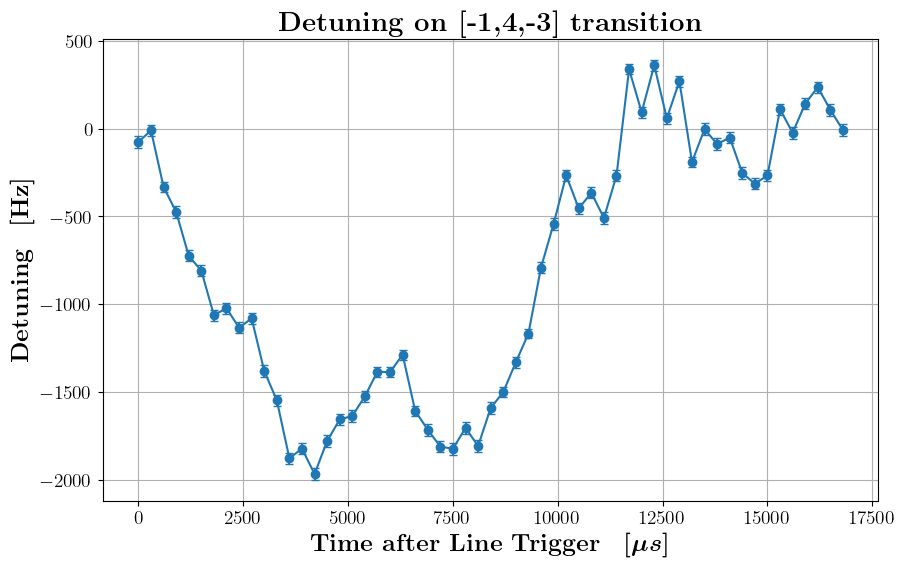

In [122]:
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

plt.figure(figsize=(10, 6))
# plt.plot(
#     fit_wait_times_list,
#     fit_phases_list)
plt.errorbar(
    fit_wait_times_list,
    np.array(fit_detunings_list)/(2*np.pi),
    yerr=np.array(fit_detuning_errors_list)/(2*np.pi),
    fmt='-o',
    capsize=3
)

plt.xlabel(r'\boldmath$\textbf{Time after Line Trigger}\quad [\mu s]$', fontsize=18)
plt.ylabel(r'\boldmath$\textbf{Detuning}\quad [\mathrm{Hz}]$', fontsize=18)
plt.title(r'\textbf{Detuning on [-1,4,-3] transition}', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.savefig('0_2_0_phase_offsets_for_laser_noise_with_RFSoC.png', dpi=300, bbox_inches="tight")
plt.show()

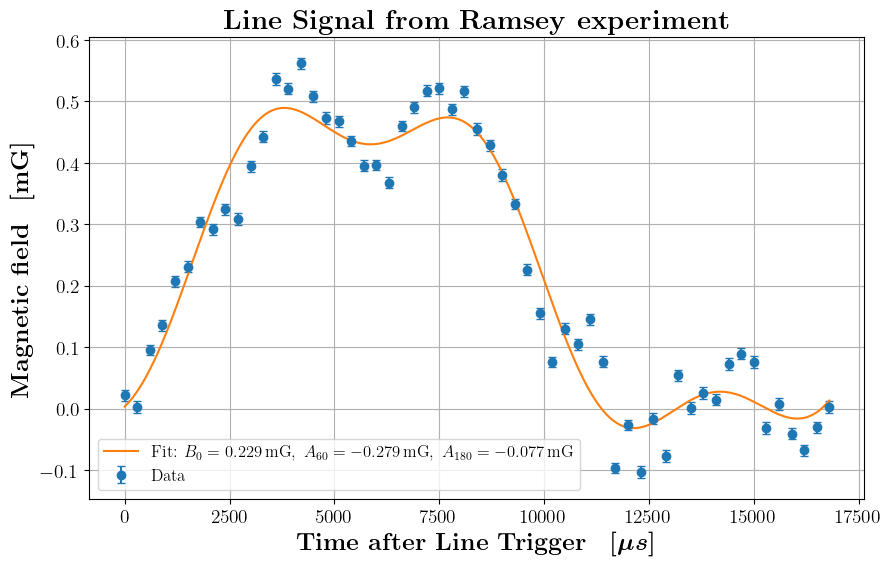

Fitted line-synchronous field (mG):
  B0      = 0.2289 ± 0.0012 mG
  A_60    = -0.2791 ± 0.0017 mG
  phi_60  = 1.0002 ± 0.0060 rad
  A_180   = -0.0774 ± 0.0017 mG
  phi_180 = -0.2650 ± 0.0221 rad


In [113]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

fit_wait_times_array = np.array(fit_wait_times_list, dtype=float)
B_array = (np.array(fit_detunings_list, dtype=float) / (-3.49924441e3)) / (2 * np.pi)
B_err_array = np.array(fit_detuning_errors_list, dtype=float) / (3.49924441e3) / (2 * np.pi)

mask = np.isfinite(fit_wait_times_array) & np.isfinite(B_array) & np.isfinite(B_err_array)
t_us = fit_wait_times_array[mask]
B = B_array[mask]
B_err = B_err_array[mask]

def line_signal_model(t_us, B0, A60, phi60, A180, phi180):
    t_s = t_us * 1e-6
    return (
        B0
        + A60 * np.cos(2 * np.pi * 60 * t_s + phi60)
        + A180 * np.cos(2 * np.pi * 180 * t_s + phi180)
    )

B0_0 = np.mean(B)
A_guess = 0.5 * (np.max(B) - np.min(B))
p0 = [B0_0, A_guess, 0.0, 0.3 * A_guess, 0.0]

params, covariance = curve_fit(
    line_signal_model,
    t_us,
    B,
    p0=p0,
    sigma=B_err,
    absolute_sigma=True,
    maxfev=20000
)

B0_fit, A60_fit, phi60_fit, A180_fit, phi180_fit = params
if covariance is not None:
    perr = np.sqrt(np.diag(covariance))
else:
    perr = [np.nan] * len(params)
B0_err, A60_err, phi60_err, A180_err, phi180_err = perr

t_fine_us = np.linspace(t_us.min(), t_us.max(), 2000)
B_fit_curve = line_signal_model(t_fine_us, *params)

plt.figure(figsize=(10, 6))
plt.errorbar(
    fit_wait_times_list,
    B_array,
    yerr=B_err_array,
    fmt='o',
    capsize=3,
    label=r'Data'
)
plt.plot(
    t_fine_us,
    B_fit_curve,
    label=(
        r'Fit: $B_0={:.3f}\,\mathrm{{mG}},\ A_{{60}}={:.3f}\,\mathrm{{mG}},\ '
        r'A_{{180}}={:.3f}\,\mathrm{{mG}}$'
    ).format(B0_fit, A60_fit, A180_fit)
)

plt.xlabel(r'\boldmath$\textbf{Time after Line Trigger}\quad [\mu s]$', fontsize=18)
plt.ylabel(r'\boldmath$\textbf{Magnetic field}\quad [\mathrm{mG}]$', fontsize=18)
plt.title(r'\textbf{Line Signal from Ramsey experiment}', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.legend(fontsize=12)
plt.savefig('line_signal_fit_60_180Hz.png', dpi=300, bbox_inches="tight")
plt.show()

print("Fitted line-synchronous field (mG):")
print("  B0      = {:.4f} ± {:.4f} mG".format(B0_fit, B0_err))
print("  A_60    = {:.4f} ± {:.4f} mG".format(A60_fit, A60_err))
print("  phi_60  = {:.4f} ± {:.4f} rad".format(phi60_fit, phi60_err))
print("  A_180   = {:.4f} ± {:.4f} mG".format(A180_fit, A180_err))
print("  phi_180 = {:.4f} ± {:.4f} rad".format(phi180_fit, phi180_err))


In [118]:
import numpy as np

def compute_detuning_from_line_fit(
    pulse_train,
    fractions,
    pi_t=[23.76, 36.54, 106.33, 32.755, 39.168],
    B0=0.2289,
    A60=-0.2791,
    phi60=1.0002,
    A180=-0.0774,
    phi180=-0.2650
):
    def B_line_mG(t, B0=B0, A60=A60, phi60=phi60, A180=A180, phi180=phi180):
        return B0 + A60 * np.cos(2 * np.pi * 60 * t + phi60) + A180 * np.cos(2 * np.pi * 180 * t + phi180)

    def B_rel_G(t):
        return (B_line_mG(t) - B_line_mG(0.0)) * 1e-3

    def compute_pi_times(pi_t):
        transition_strengths = np.loadtxt(
            'Z:\\Lab Data\\Phase_and_freq_correction_180Hz\\Transition_strengths_4p216.txt',
            delimiter=','
        )
        transition_strengths[transition_strengths == 0] = np.nan
        strengths = np.array([
            transition_strengths[22, 1],
            transition_strengths[14, 0],
            transition_strengths[5, 2],
            transition_strengths[16, 4],
            transition_strengths[15, 4]
        ])
        factors = np.array(pi_t) * strengths
        Fs = [1, 2, 3, 4]
        row_labels = [[i, i - j] for i in Fs for j in range(2 * i + 1)]
        col_labels = [-2, -1, 0, 1, 2]
        pi_times = np.zeros((24, 5))
        for i in range(np.shape(transition_strengths)[0]):
            for j in range(np.shape(transition_strengths)[1]):
                if not np.isnan(transition_strengths[i, j]):
                    delta_m = (row_labels[i][1] - col_labels[j]) + 2
                    pi_times[i, j] = factors[delta_m] / transition_strengths[i, j]
        return pi_times

    def get_pi_times(transitions, matrix):
        Fs = [1, 2, 3, 4]
        states = []
        for i in Fs:
            for j in range(2 * i + 1):
                mF = i - j
                states.append([i, mF])
        row_labels = states
        col_labels = [-2, -1, 0, 1, 2]
        pi_times_list = []
        for transition in transitions:
            row_label = [transition[1], transition[2]]
            col_label = transition[0]
            row_index = next((k for k, label in enumerate(row_labels) if label == row_label), None)
            col_index = col_labels.index(col_label) if col_label in col_labels else None
            if row_index is not None and col_index is not None:
                pi_times_list.append(matrix[row_index, col_index])
            else:
                pi_times_list.append(np.nan)
        return pi_times_list

    def get_pulse_schedule(rabi_freqs, fractions):
        if len(rabi_freqs) != len(fractions):
            raise ValueError(f"rabi_freqs {len(rabi_freqs)} and fractions {len(fractions)} must have the same length.")
        times = []
        t_current = 0.0
        for Omega, frac in zip(rabi_freqs, fractions):
            if not 0 <= frac <= 1:
                raise ValueError(f"Fraction must be between 0 and 1, got {frac}.")
            theta = 2.0 * np.arcsin(np.sqrt(frac))
            t_pulse = theta / Omega if Omega > 0 else 0.0
            t_start = t_current
            t_end = t_current + t_pulse
            times.append((t_start, t_end))
            t_current = t_end
        return times

    pi_times_matrix = compute_pi_times(pi_t)
    pi_times_train = get_pi_times(pulse_train, pi_times_matrix)
    for i, tr in enumerate(pulse_train):
        if tr[0] == 0 and tr[1] == 0 and tr[2] == 0:
            pi_times_train[i] = 1e6
    rabi_frequencies_list = np.pi / np.array(pi_times_train)

    sens_matrix = np.loadtxt(
        'Z:\\Lab Data\\Phase_and_freq_correction_180Hz\\sensitivities_4p216.txt',
        delimiter=','
    )
    sens_list = get_pi_times(pulse_train, sens_matrix)
    for i, tr in enumerate(pulse_train):
        if tr[0] == 0 and tr[1] == 0 and tr[2] == 0:
            sens_list[i] = 0.0
    sens_array = np.array(sens_list)
    print(sens_array)
    schedule = get_pulse_schedule(rabi_frequencies_list, fractions)
    pulses_sec = [(start * 1e-6, end * 1e-6) for (start, end) in schedule]
    print(pulses_sec)
    detuning_values_MHz = []
    for i, (start_s, _) in enumerate(pulses_sec):
        B_here_G = B_rel_G(start_s)
        det_here_MHz = B_here_G * sens_array[i]
        detuning_values_MHz.append(det_here_MHz)

    detuning_values_MHz = np.array(detuning_values_MHz, dtype=float)
    return detuning_values_MHz


In [119]:
pulse_train = [[0,0,0], [-1,4,-3], [0,0,0], [-1,4,-3]]
fractions = [(np.sin((4000/1e6)*(np.pi/2)))**2, 0.5, (np.sin((100/1e6)*(np.pi/2)))**2, 0.5]

detuning_values = compute_detuning_from_line_fit(pulse_train, fractions)
print(detuning_values)

[ 0.         -3.49924441  0.         -3.49924441]
[(0.0, np.float64(0.004)), (np.float64(0.004), np.float64(0.00401188)), (np.float64(0.00401188), np.float64(0.00411188)), (np.float64(0.00411188), np.float64(0.00412376))]
[ 0.         -0.00169474  0.         -0.00168674]
